#### Computational Modeling of Cognition and Behavior

# 2 From Words to Models
## Building a Toolkit

***

## 2.1 Response Times in Speeded-Choice Tasks

***

<br>

"Choice rection time" task (Smith and Vickers 1998)

<br>

Can be approached using a "random walk model":

<br>

Simple model assumptions:

- Evidence for a decision is built up gradually.

- Evidence is sampled at discrete time steps.

- Sampling starts with 0 evidence


How the model works:

- Magnitude of discrete nudges towards a decision reflects the information available at a single sample.

- Sampled evidence is summed accross time steps until a response threshold is reached.

- Sampling starts with 0 evidence and moves towards one of two thresholds, each representing a choice (left/righ for example).

Some conclusions:

- If the two thresholds are equidistant from 0, the reponse times should be equal.


Prediction of the model:

- Response time is dependent on evidence 

<br>

## 2.1 Response Times in Speeded-Choice Tasks

***
<br>

### 2.2.1 Getting started

<br>

### 2.2.2 The Random-Walk Model

<br>

First, a function is created to simulate a single trial, it takes the decision variable drift for a single trial and a threshold as it's inputs.

<br>


In [4]:
import numpy as np


def random_walk_trial(acc_drift_row, threshold):
    """
    Single trial for a random walk model of decision making.

    Parameters
    ----------
    acc_drift_row : numpy.ndarray
        A single row numpy array, containing a cumulative sum of random 
        increments.

    threshold : float
        The value of evidence at which a decision is made.

    Returns
    -------
    acc_drift_row : numpy.ndarray
        A single row numpy array, containing a cumulative sum of random 
        increments. Once a value reaches the threshold the trial is over
        and following values are set to NaN.

    trial_latency : int
        The index which a decision is made (the evidence crosses a 
        threshold). -1 if no decision is made.

    trial_response : int
        + 1 for decision made for upper threshold, -1 when decision made 
        for negative threshold, 0 for no decision made.
    """
    try:
        # look for the first index when the threshold is crossed
        trial_latency = np.where(np.abs(acc_drift_row) >= threshold)[0][0]
    # if the index is never crossed
    except IndexError:  
        trial_latency = -1  # no latency
    if trial_latency == -1:
        trial_response = 0  # no response
    # if the index is crossed
    else:
        trial_response = np.sign(acc_drift_row[trial_latency])
        # After the decision is made the trial ends
        acc_drift_row[trial_latency + 1:] = np.NaN
    return acc_drift_row, trial_latency, trial_response


<br>

Then, a function is created to generate evidence, with a row for every trial. A third function runs the random walk model on every trial. Two dataframes are output. 'df_trial_data' gives a trial per row, containing the trial response and trail latency (time taken to make a decision). The second dataframe 'df_dv' contains the decision variable (dv) for every time point (rows) for every trial (columns). 

<br>

**Note**: Model is not an evidence accumulator model! Evidence fixes the centre of a distribution of drift.


In [5]:
import pandas as pd

def gen_drift(evidence, sd_rw, nreps, nsamples):
    """
    Generate random drift, of a decision variable dependent on evidence
    
     Parameters
    ----------
    evidence : float
        The evidence given by the stimuli. The drift of the decision 
        variable is defined by increments drawn from a random normal 
        distribution with this mean value.
        
    sd_rw : float
        The drift of the decision variable is defined by increments 
        drawn from a random normal distribution with this standard 
        deviation.
        
    nreps : int
        The number of trials.

    nsamples : int
        The length of each trial.

    Returns
    -------
    acc_drift : numpy.ndarray
        A 2d numpy array representing the drift of the decision variable. 
        Each row is a trial and each column is a sample (time point).
        """
    start_zero_drift = np.zeros((nreps, 1))
    rand_norm_incr = np.random.normal(loc=evidence,
                                      scale=sd_rw,
                                      size=[nreps, nsamples])
    drift_incr = np.concatenate((start_zero_drift, rand_norm_incr),
                                   axis=1)
    acc_drift = drift_incr.cumsum(axis=1)
    return acc_drift

def random_walk(nreps, threshold, acc_drift):
    """
    Random walk model of decision making.
    
    Parameters
    ----------
    nreps : int
        The number of trials.
        
    threshold : float
        The value of evidence at which a decision is made.
              
    acc_drift : numpy.ndarray
        A numpy array representing the drift of the decision variable.

    Returns
    -------
    df_dv : pandas.core.frame.DataFrame
        A DataFrame containing a column per trial, row per time point.
        Data represents the decision variable (internal evidence).
        
    df_trial_data : pandas.core.frame.DataFrame
        A DataFrame containing two columns trial_latency and
         trial_response. Note that the length of columns is n_reps.
    
    """
    # run the random walk function on every row of drift
    dv, trial_latency, trial_response = zip(*[random_walk_trial(acc_drift_row, threshold)
                                              for acc_drift_row
                                              in acc_drift])
    column_names = ["trial_" + str(trial_n + 1) for trial_n in np.arange(nreps)]
    dv_array = np.asarray(dv).T
    df_dv = pd.DataFrame(data=dv_array,
                         columns=column_names)
    df_trial_data = pd.DataFrame(data={'trial_latency': trial_latency,
                                       'trial_response': trial_response})
    return df_dv, df_trial_data

<br>

Then I set some specific values to variables and run a simulation.

<br>


In [6]:
from IPython.display import display

nreps = 10000
nsamples = 500
evidence = 0    # the amount of evidence, 0 gives a random decision 
sd_rw = 0.3     # standard deviation of the random walk 
threshold = 3

acc_drift = gen_drift(evidence,
                      sd_rw,
                      nreps,
                      nsamples)
df_dv, df_trials = random_walk(nreps,
                               threshold,
                               acc_drift)

evidence = 0.03  # the amount of evidence, 0.3 gives a decision to the above boundry

acc_drift = gen_drift(evidence,
                      sd_rw,
                      nreps,
                      nsamples)
df_dv_above, df_trials_above = random_walk(nreps,
                                           threshold,
                                           acc_drift)

display(df_dv)
display(df_trials)

,trial_1,trial_2,trial_3,trial_4,trial_5,trial_6,trial_7,trial_8,trial_9,trial_10,...,trial_9991,trial_9992,trial_9993,trial_9994,trial_9995,trial_9996,trial_9997,trial_9998,trial_9999,trial_10000
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.178273,-0.063681,0.032001,-0.024872,0.134803,0.364676,-0.333662,-0.014119,-0.028238,0.593018,...,-0.146144,0.518663,0.423087,0.089996,0.691491,-0.306551,0.282471,0.154855,-0.482294,0.030244
2,0.282397,-0.186155,0.002603,-0.670775,-0.085692,0.457181,-0.880305,-0.184966,0.545500,0.406065,...,-0.085988,0.269796,-0.300169,-0.297582,0.965517,0.300676,-0.000706,-0.072426,-0.077465,-0.049867
3,0.377828,0.129584,0.053138,-0.825462,-1.156935,0.827811,-0.831638,0.241301,0.504862,1.705000,...,-0.001592,0.285740,-0.789930,-0.500967,1.045187,0.239063,0.135854,-0.348568,-0.144243,-0.189992
4,0.356550,0.472005,-0.178424,-0.370659,-0.801572,1.188962,-0.849952,0.491239,0.461754,1.851471,...,-0.052968,0.954405,-1.061804,-0.147367,1.636762,-0.219359,0.041711,-0.259009,-0.430992,-0.188990
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
496,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
497,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
498,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
499,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,trial_latency,trial_response
0,373,1.0
1,38,1.0
2,11,-1.0
3,34,-1.0
4,84,-1.0
...,...,...
9995,81,1.0
9996,48,1.0
9997,106,1.0
9998,46,-1.0


<br>

From this point, it is simple to plot and visualise the decision variable for several trials.

<br>

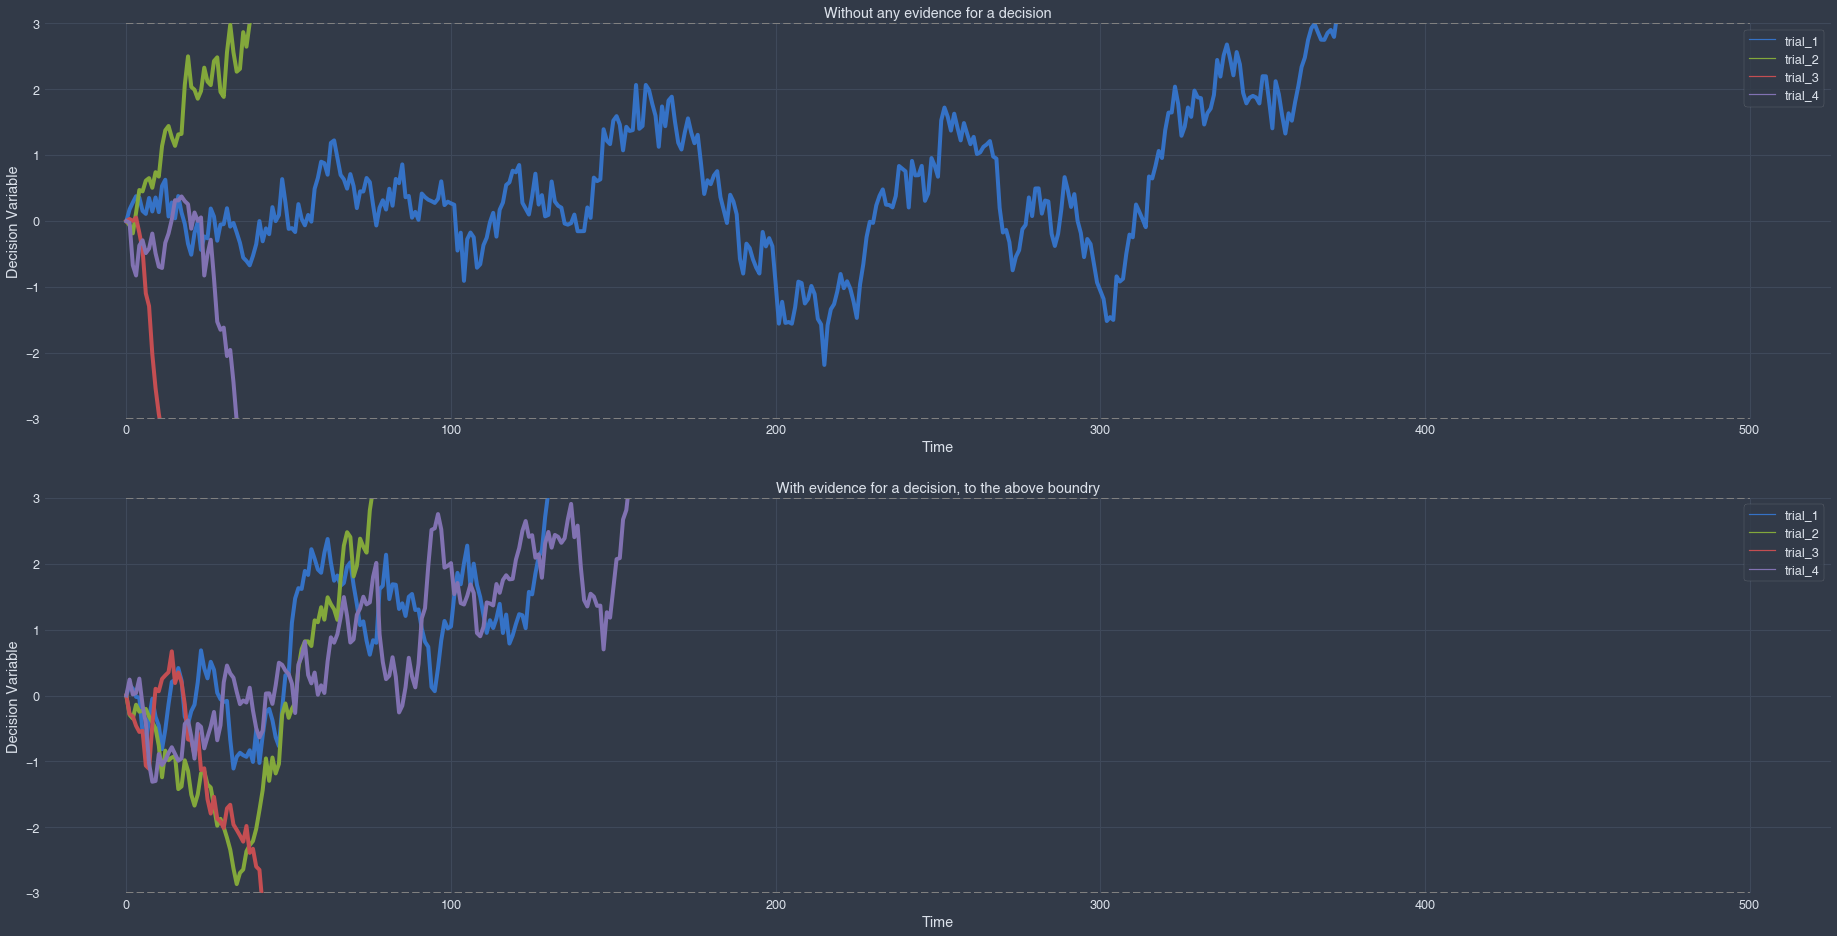

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
from jupyterthemes import jtplot
jtplot.style('chesterish',
             spines=False,
             figsize=(40, 20))

plt.subplot(2, 1, 1)
plt.xlabel('Time')
plt.ylabel('Decision Variable')
plt.title('Without any evidence for a decision')
plt.ylim(-3,3)
sns.lineplot(data=df_dv.iloc[:, 0:4],
             dashes=False,
             linewidth=4);
plt.plot([0, nsamples], [3, 3],
         linestyle='--',
         linewidth=2,
         c='grey');
plt.plot([0, nsamples], [-3, -3],
         linestyle='--',
         linewidth=2,
         c='grey');

plt.subplot(2, 1, 2)
plt.xlabel('Time')
plt.ylabel('Decision Variable')
plt.title('With evidence for a decision, to the above boundry')
plt.ylim(-3,3)
sns.lineplot(data=df_dv_above.iloc[:, 0:4],
             dashes=False,
             linewidth=4);
plt.plot([0, nsamples], [3, 3],
         linestyle='--',
         linewidth=2,
         c='grey');
plt.plot([0, nsamples], [-3, -3],
         linestyle='--',
         linewidth=2,
         c='grey');


<br>

And view the distribution of latencies in a histogram, seperated by choice (high boundry, low boundry):

<br>

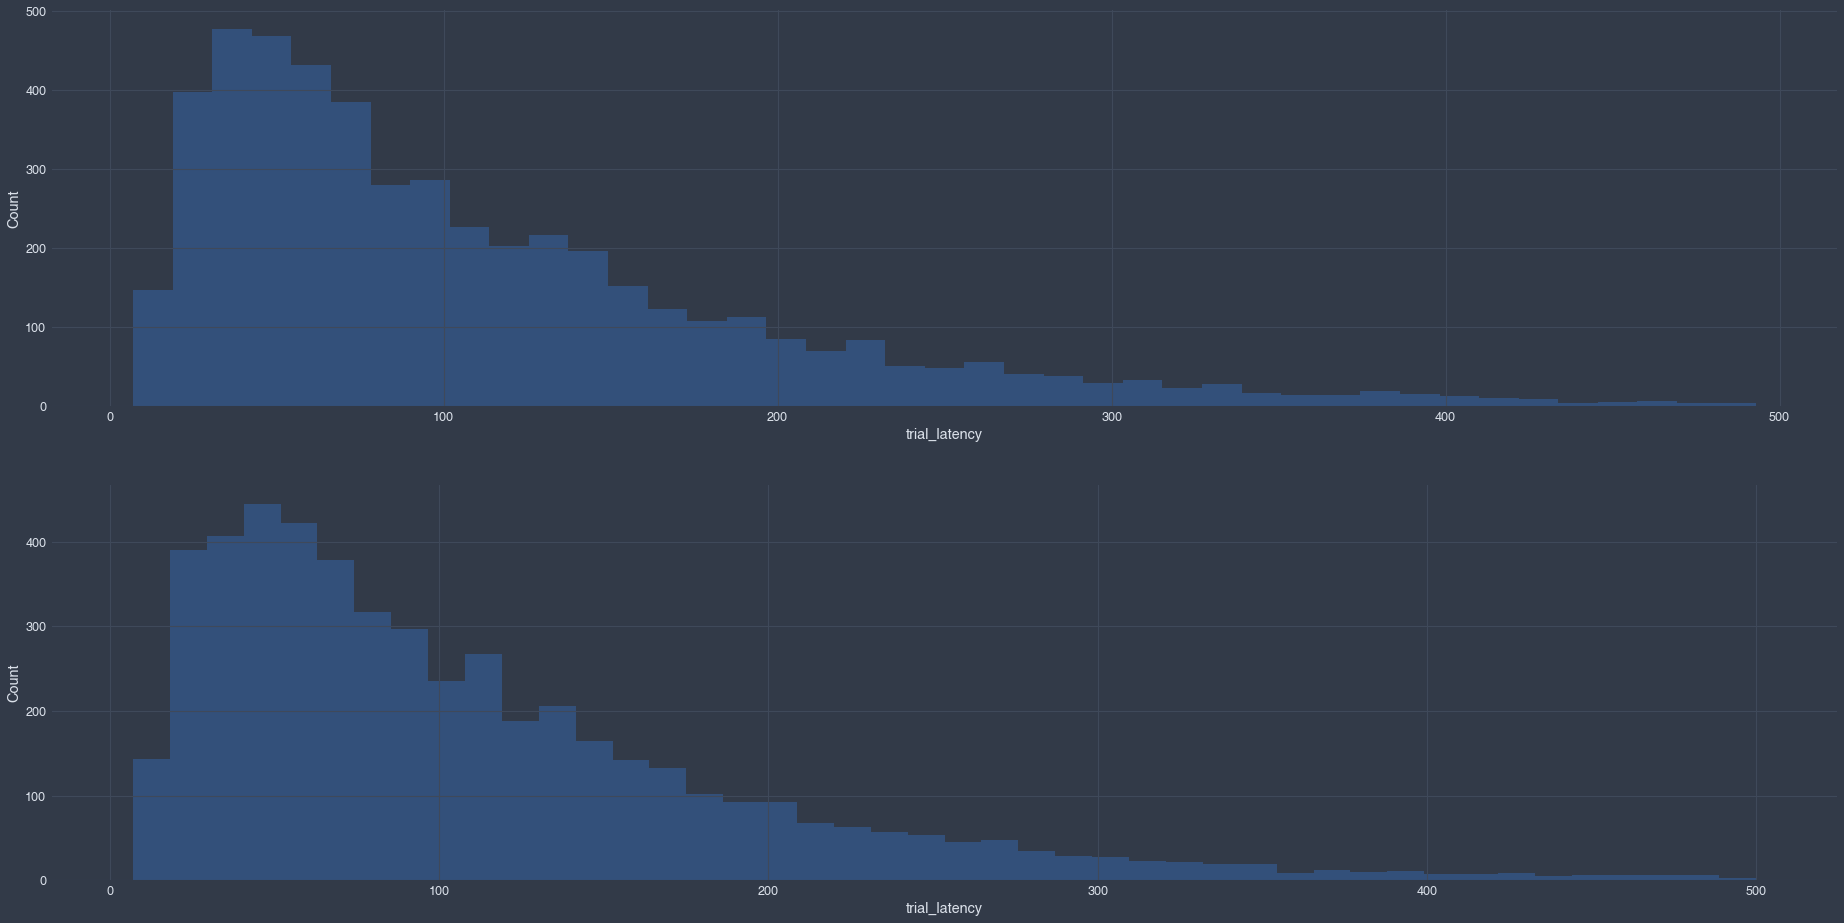

In [8]:
plt.subplot(2, 1, 1)
plt.ylabel('Count')
sns.distplot(df_trials.trial_latency[df_trials.trial_response == 1],  # high boundry
            kde=False);
plt.subplot(2, 1, 2)
plt.ylabel('Count')
sns.distplot(df_trials.trial_latency[df_trials.trial_response == -1],  # low boundry
            kde=False);

<br> 

The same can be done for the example with evidence 0.03, drifting more to the above boundry

<br>



(0.0, 498.0)

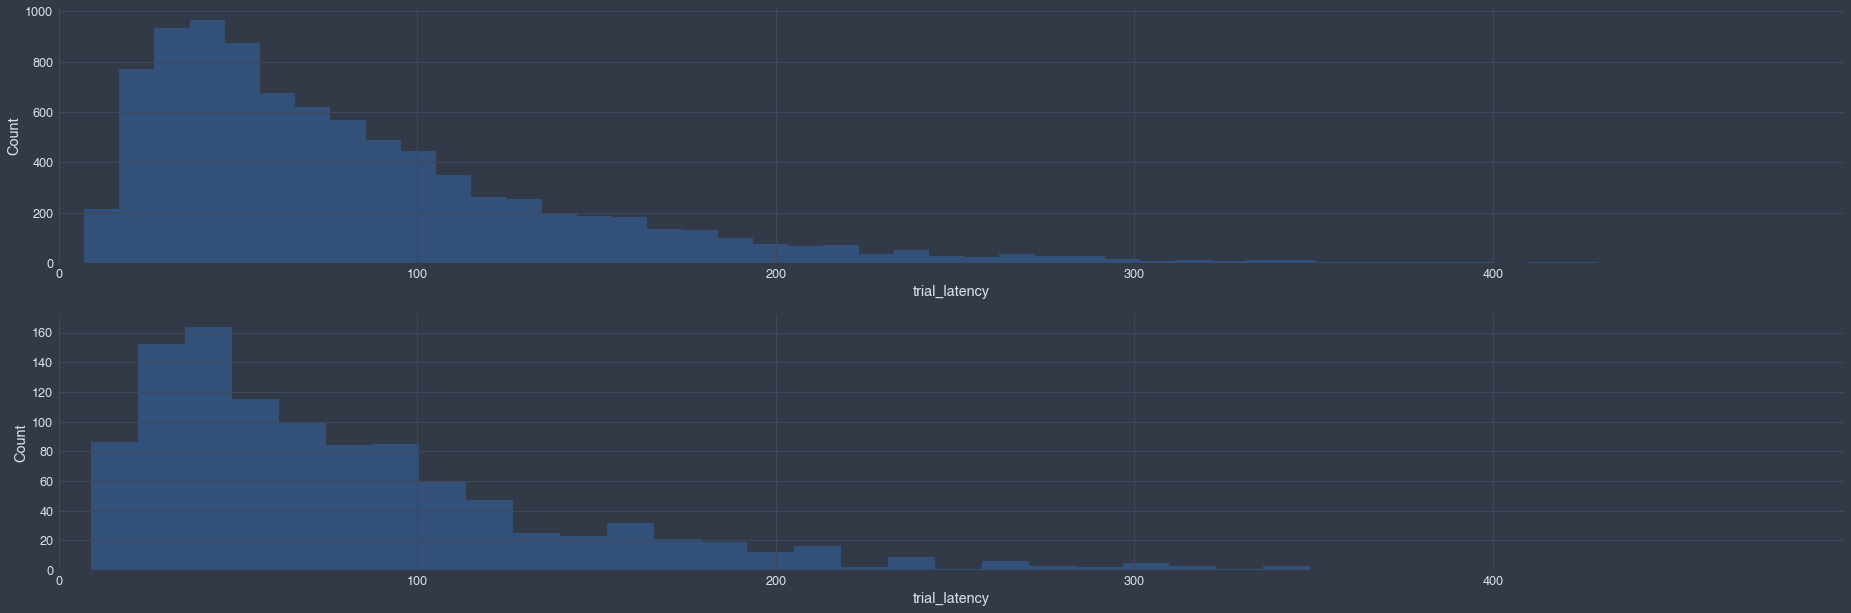

In [9]:
plt.subplot(3, 1, 1)
plt.ylabel('Count')
sns.distplot(df_trials_above.trial_latency[df_trials_above.trial_response == 1],  # high boundry
            kde=False);
plt.xlim(0, max(df_trials_above.trial_latency))

plt.subplot(3, 1, 2)
plt.ylabel('Count')
sns.distplot(df_trials_above.trial_latency[df_trials_above.trial_response == -1],  # low boundry
             kde=False);
plt.xlim(0, max(df_trials_above.trial_latency))


<br>

Even though the counts are much lower for the below side, when there is evidence for above, the distribtuion of the latencies is similar. The longer a trial goes on, the more likely it is to be drifted to the evidenced side. 

<br>

Both the starting point of the decision variable and the drift can vary randomly trial to trial. Below, is a function to introduce noise to both the starting point and the drift.

In [ ]:
def gen_drift_with_noise(evidence, sd_rw, nreps, nsamples, start_noise, evidence_noise):
    """
    Generate random drift, of a decision variable dependent on evidence. 
    Includes noise to the starting evidence and the standard deviation of the
    drift
    
    
    Parameters
    ----------
    evidence : float
        The evidence given by the stimuli. The drift of the decision 
        variable is defined by increments drawn from a random normal 
        distribution with this mean value.
        
    sd_rw : float
        The drift of the decision variable is defined by increments 
        drawn from a random normal distribution with this standard 
        deviation.
        
    nreps : int
        The number of trials.

    nsamples : int
        The length of each trial.
        
    start_noise : int
        The standard deviation of the noise on the starting point of the
        decision variable.
        
    evidence_noise : int

    Returns
    -------
    acc_drift : numpy.ndarray
        A 2d numpy array representing the drift of the decision variable. 
        Each row is a trial and each column is a sample (time point).
        """
    trial_start = np.random.normal(loc=0,
                                   scale=start_noise,
                                   size=[nreps, 1])
    drift_sd = np.random.normal(loc=sd_rw,
                                scale=evidence_noise,
                                size=[nreps, nsamples])
    rand_norm_incr = np.random.normal(loc=evidence,
                                      scale=drift_sd,
                                      size=[nreps, nsamples])
    drift_incr = np.concatenate((trial_start, rand_norm_incr),
                                axis=1)
    acc_drift = drift_incr.cumsum(axis=1)
    return acc_drift

<br>
Then run an example of each:
<br>


In [51]:
start_noise = 0.8
evidence_noise = 0

noisy_start_drift = gen_drift_with_noise(evidence,
                                         sd_rw,
                                         nreps,
                                         nsamples,
                                         start_noise,
                                         evidence_noise)
df_dv_above_noisy_start, df_trials_above_noisy_start = random_walk(nreps,
                                                                   threshold,
                                                                   noisy_start_drift)
start_noise = 0
evidence_noise = 0.05

noisy_evidence_drift = gen_drift_with_noise(evidence,
                                            sd_rw,
                                            nreps,
                                            nsamples,
                                            start_noise,
                                            evidence_noise)
df_dv_above_noisy_evidence, df_trials_above_noisy_evidence = random_walk(nreps,
                                                                         threshold,
                                                                         noisy_evidence_drift)

<br>
The function below plots both the decision variable over time and latency distributions for both decisions in a single function to simplify the plotting. 
<br>
<br>

In [56]:
def plot_random_walk_with_distribution(df_dv, df_trials, titles): 
    """ 
    Create a figure with three subplots from DataFrames representing 
    a random walk model. The first shows a decision variable over time 
    for 5 trials. The second two show the distribution of decision time
    latencies for each decision.
    
    Parameters
    ----------
    df_dv : pandas.core.frame.DataFrame
        A DataFrame containing a column per trial, row per time point.
        Data represents the decision variable (internal evidence).
        
    df_trial_data : pandas.core.frame.DataFrame
        A DataFrame containing two columns trial_latency and
         trial_response. Note that the length of columns is n_reps.
         
    titles : dict
        Contains titles for each subfigure, inder the keys 'dv' (figure 1)
        dist_chose_above (figure 2), dist_chose_bellow (figure 3)
        
    Returns
    -------
    fig : matplotlib.figure.Figure
        Figure object
        
    axes : tuple
        tuple of axis handles for each subfigure
    """
    fig = plt.figure()
    ax1 = plt.subplot(3, 1, 1)
    plt.xlabel('Time')
    plt.ylabel('Decision Variable')
    plt.title(titles['dv'], fontsize=18)
    plt.ylim(-3,3)
    sns.lineplot(data=df_dv.iloc[:, 0:4],
                 dashes=False,
                 linewidth=4)
    ax1.plot([0, nsamples], [3, 3],
             linestyle='--',
             linewidth=2,
             c='grey')
    plt.plot([0, nsamples], [-3, -3],
             linestyle='--',
             linewidth=2,
             c='grey')

    ax2 = plt.subplot(3, 1, 2)
    plt.title(titles['dist_chose_above'], fontsize=18)
    plt.ylabel('Count')
    sns.distplot(df_trials.trial_latency[df_trials.trial_response == 1],  # high boundry
                kde=False)
    plt.xlim(0, max(df_trials.trial_latency))
    
    ax3 = plt.subplot(3, 1, 3)
    plt.title(titles['dist_chose_below'], fontsize=18)
    plt.ylabel('Count')
    sns.distplot(df_trials.trial_latency[df_trials.trial_response == -1],  # low boundry
                 kde=False)
    plt.xlim(0, max(df_trials.trial_latency))

    fig.tight_layout(h_pad=2)
    axes = (ax1, ax2, ax3)
    return fig, axes


<br>

See page 35 (58 of 485)

<br>

Now we can easily run our noisy examples. In this case there is a leftward shift of the distribution in error trials; trial latency is shorter. In many trials, crossing the boundry was possible because of the decision variable starting at a point below 0. 

<br>



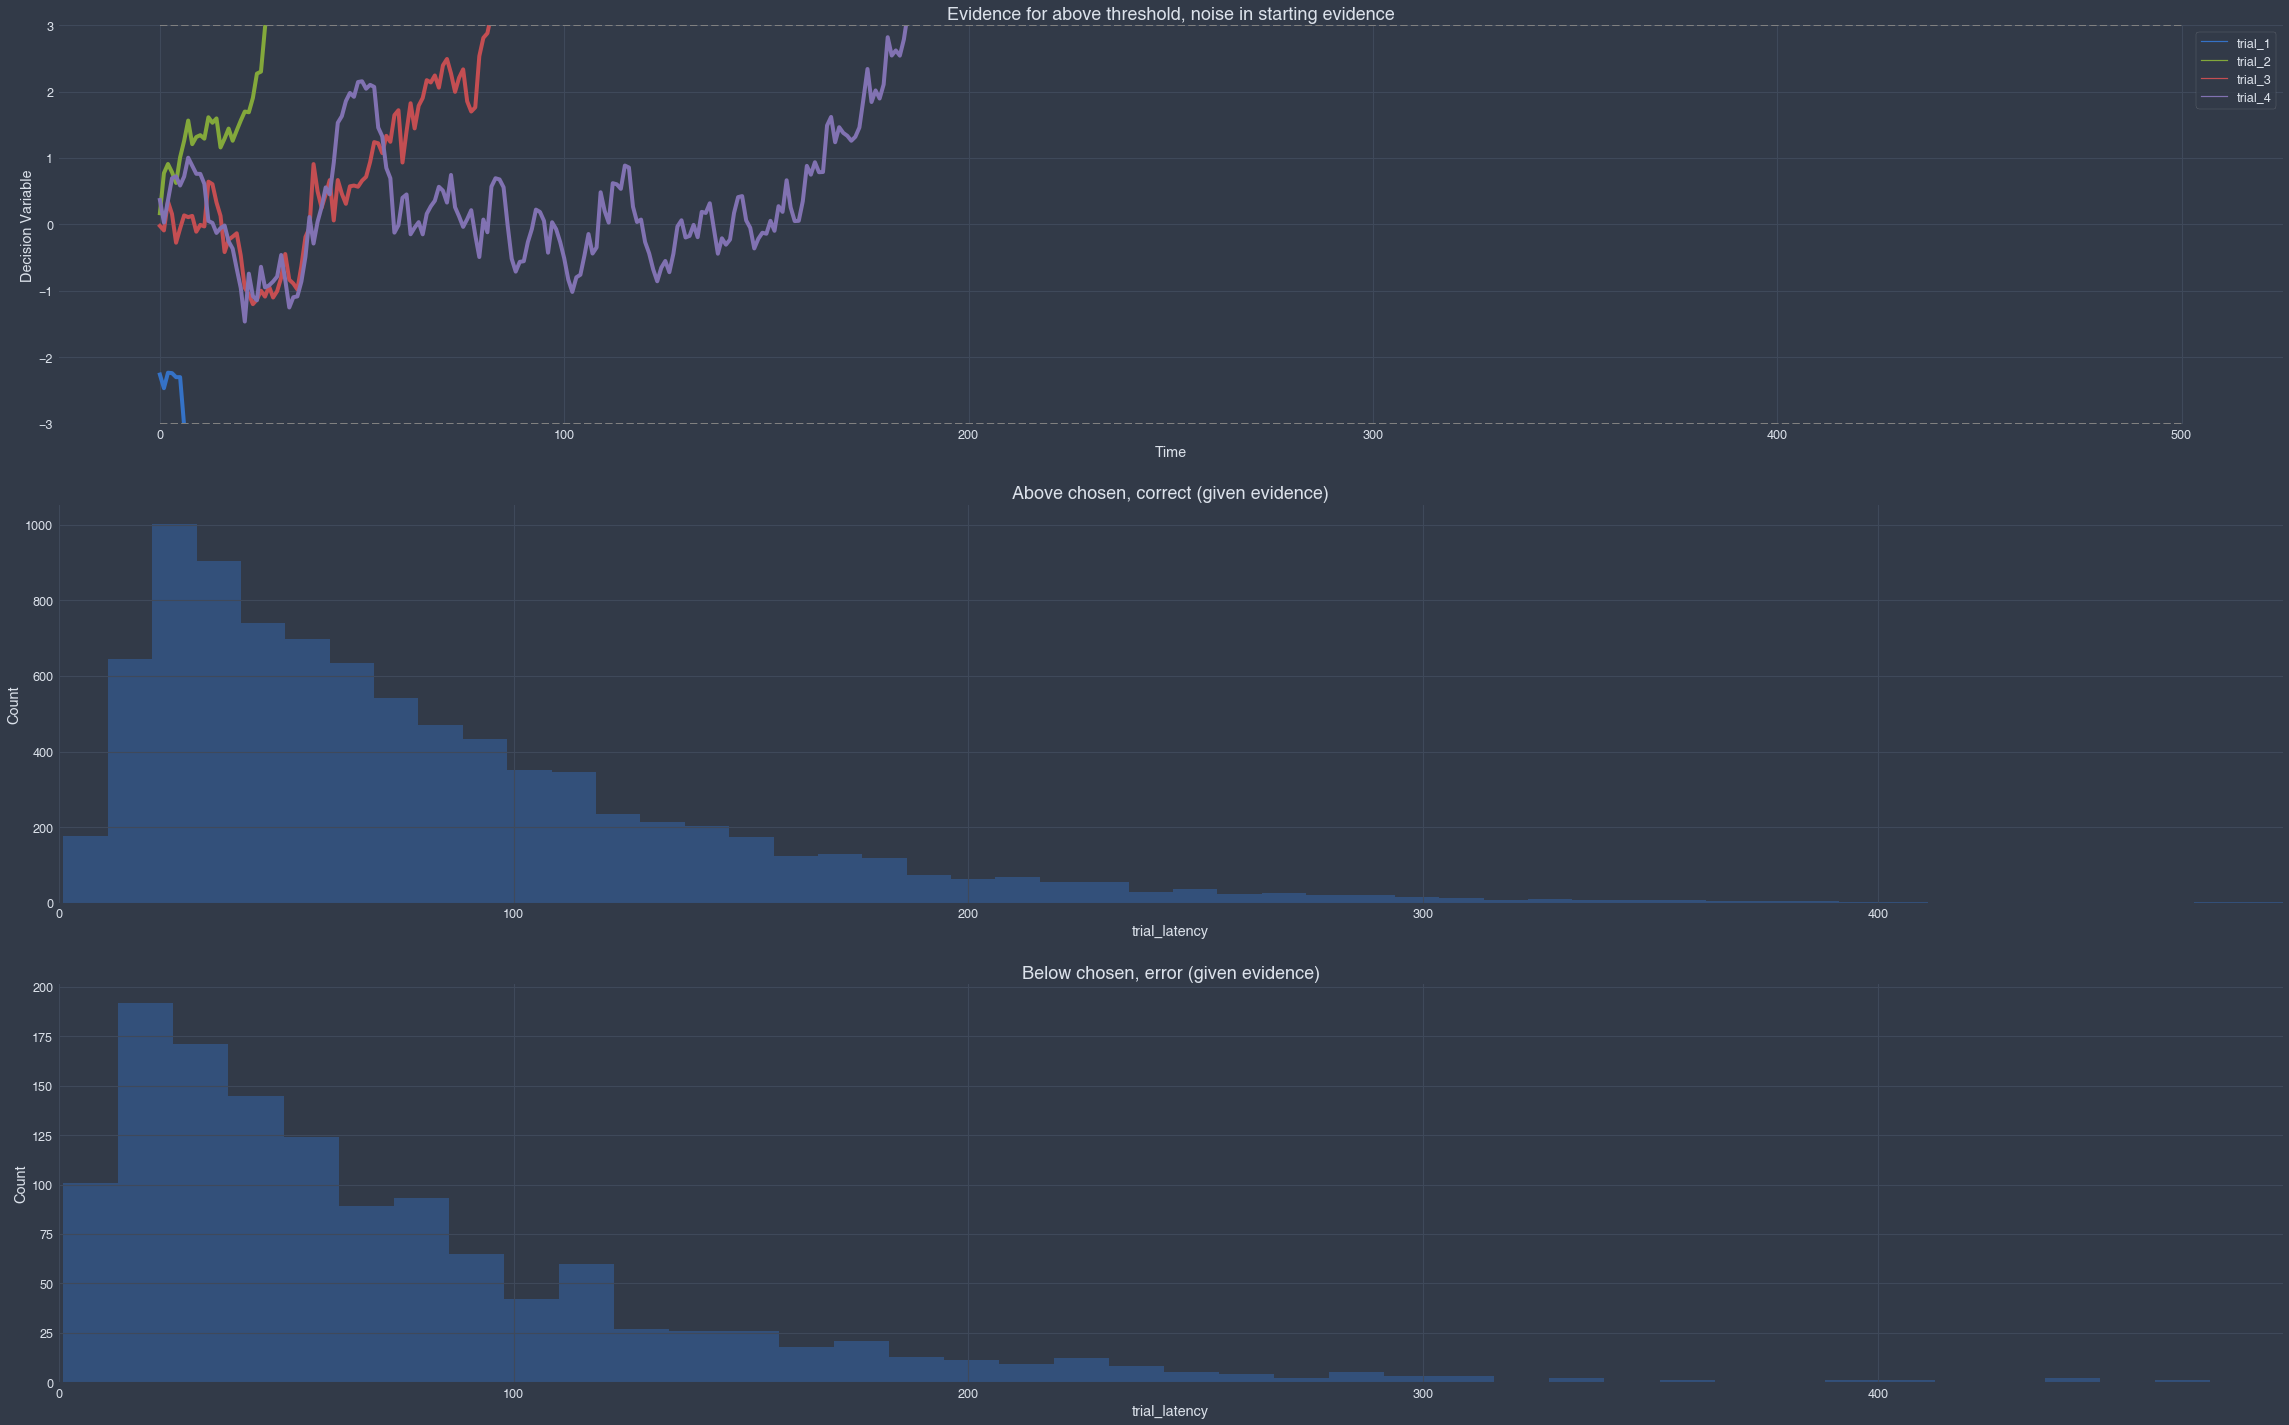

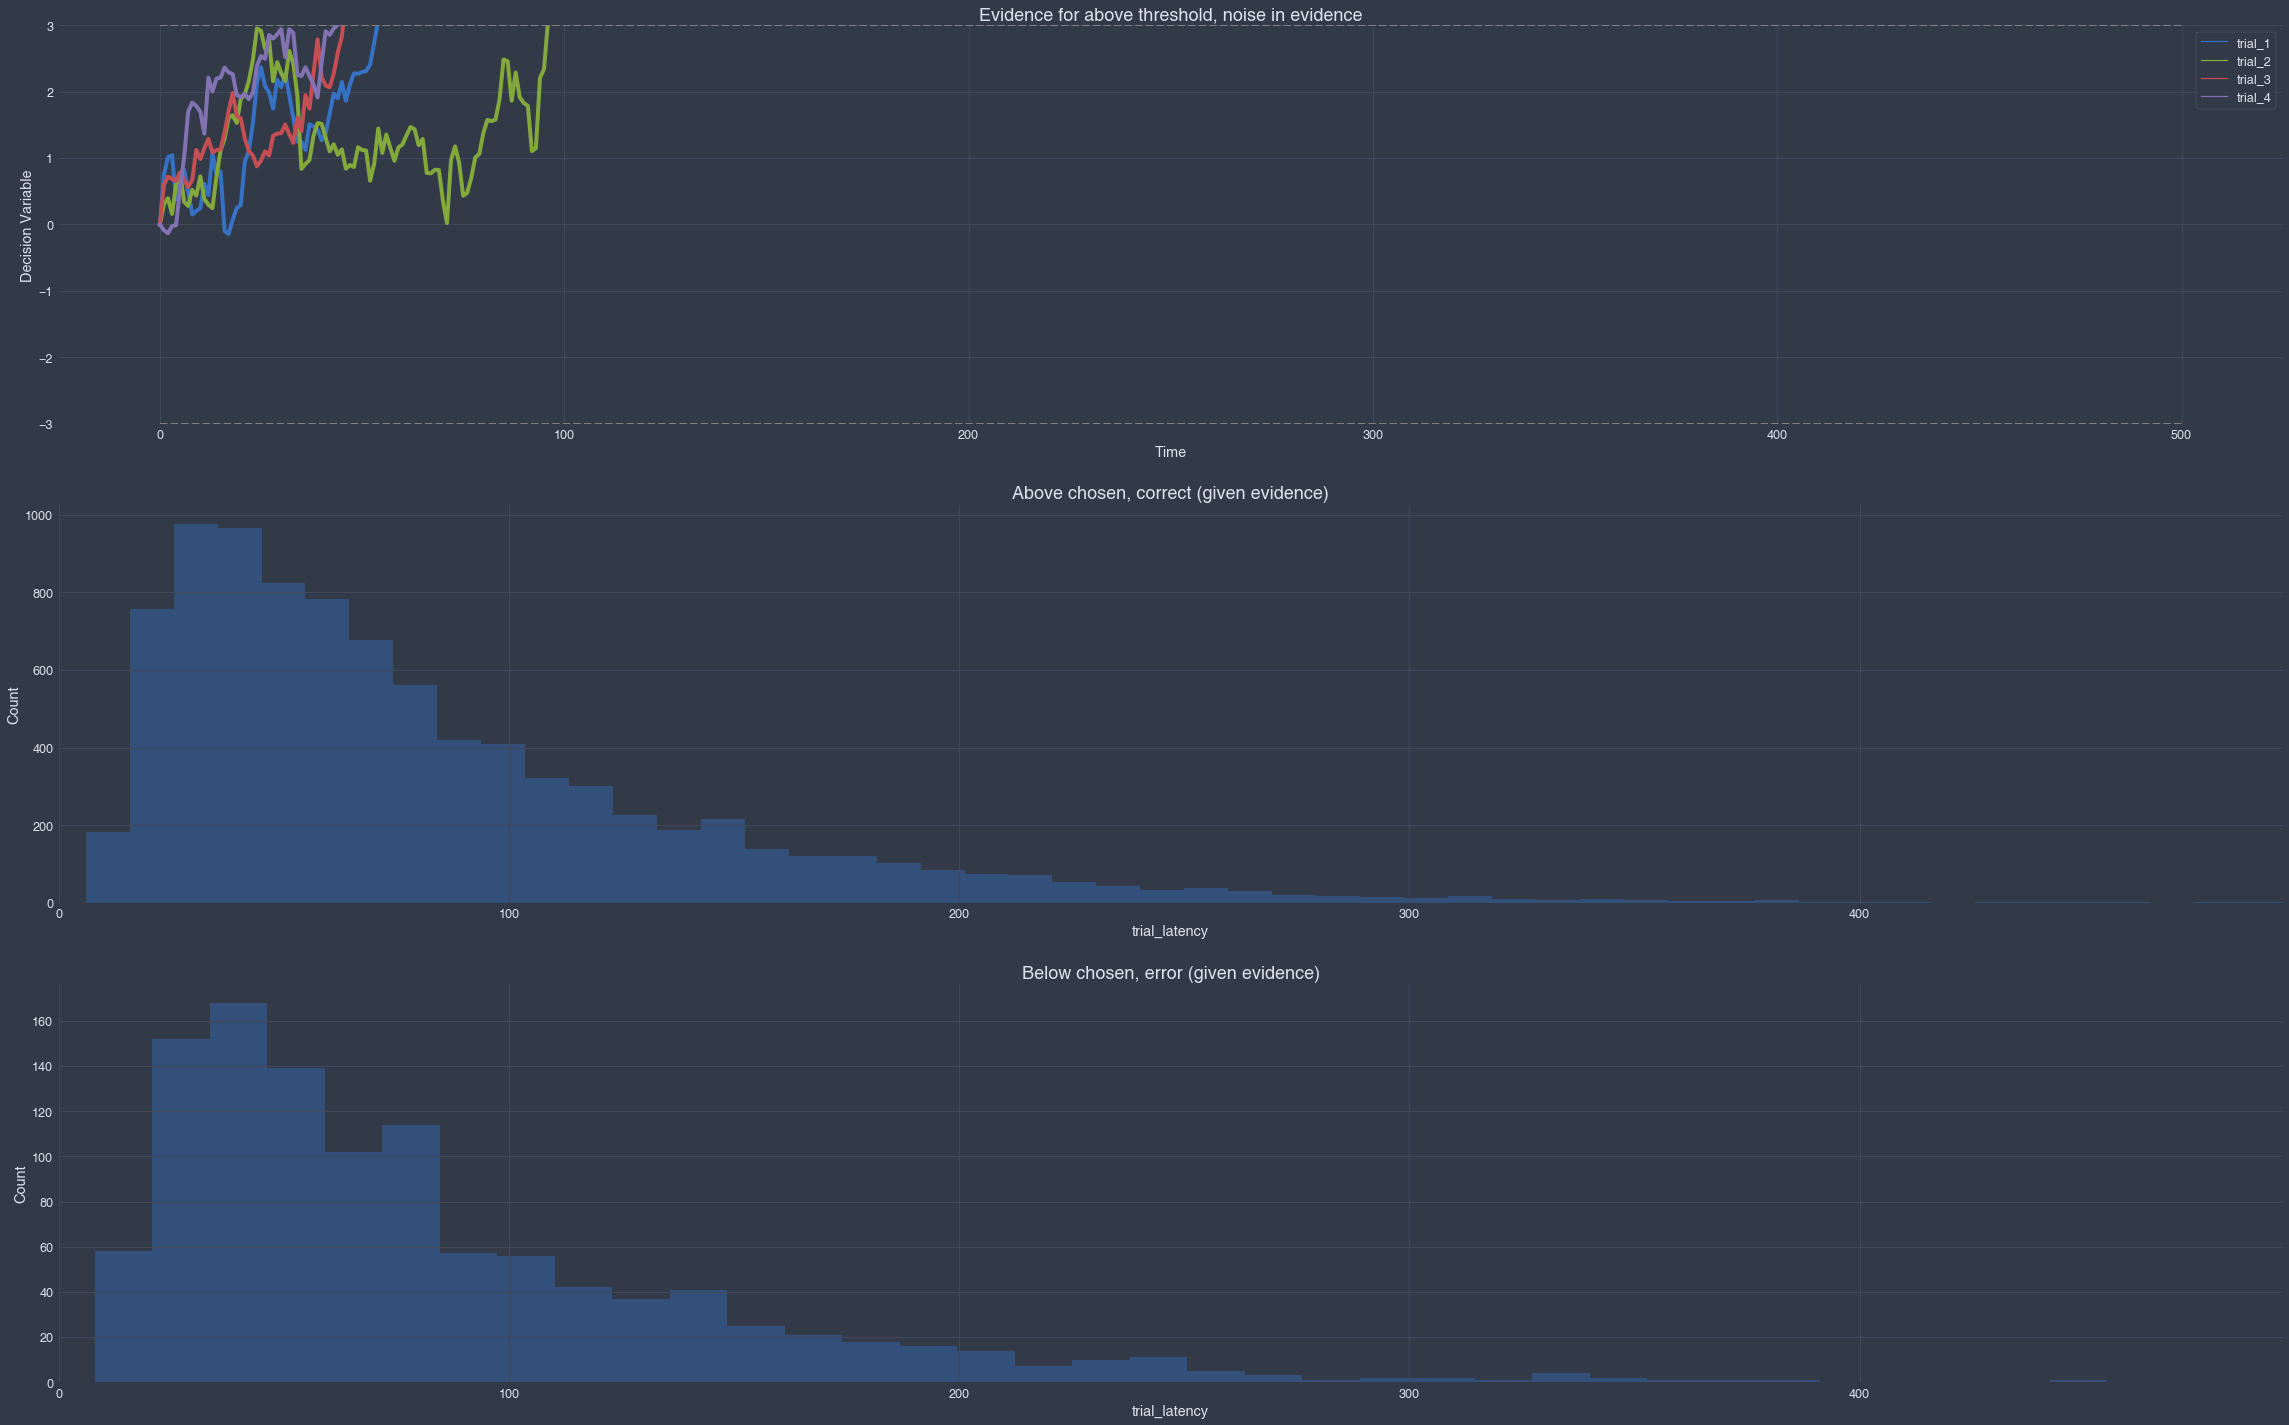

In [58]:
jtplot.style('chesterish',
             spines=False,
             figsize=(40, 25))
    
titles = {'dv': 'Evidence for above threshold, noise in starting evidence',
          'dist_chose_above': 'Above chosen, correct (given evidence)',
          'dist_chose_below': 'Below chosen, error (given evidence)'
          }
plot_random_walk_with_distribution(df_dv_above_noisy_start, df_trials_above_noisy_start, titles);

titles = {'dv': 'Evidence for above threshold, noise in evidence',
          'dist_chose_above': 'Above chosen, correct (given evidence)',
          'dist_chose_below': 'Below chosen, error (given evidence)'
          }
plot_random_walk_with_distribution(df_dv_above_noisy_evidence, df_trials_above_noisy_evidence, titles);

In [ ]:
gen_drift_with_noise
